# Introduction

Making a heatmap of differentially-expressed genes across all cell types and conditions.

# Setup

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import matplotlib as mpl
import seaborn as sns
import pickle as pkl
import itertools as it
from functools import reduce
import scanpy as sc
import scipy
import textwrap as tw
import json
import warnings
import requests
from sklearn.cluster import KMeans

from nero import Augustus as aug

In [103]:
# %load_ext autoreload
%autoreload 2

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)
sc.settings.n_jobs=30

In [3]:
mountpoint = '/data/clue/'
prefix_adts = mountpoint + 'prod/adts/'
prefix_mrna = mountpoint + 'prod/mrna/'
prefix_comb = mountpoint + 'prod/comb/'

## Load in Data

In [4]:
de = dict()
with open(prefix_mrna + 'pkls/de/IFNs.pkl', 'rb') as file:
    de['IFNs'] = pkl.load(file)
with open(prefix_mrna + 'pkls/de/all.pkl', 'rb') as file:
    de['all'] = pkl.load(file)

In [5]:
with open(mountpoint + 'meta.pkl', 'rb') as file:
    ct_colors = pkl.load(file)['ct_colors']['ct2']['hex']
with open(mountpoint + 'meta.pkl', 'rb') as file:
    cond_colors = pkl.load(file)['cond_colors']['hex']

In [6]:
de_df = de['all']['ct2']

# Prepare Data

## Create `log2fc` DataFrame

First define two sets of cts, since the PMA/I condition has the monocytes and cDCs grouped together.

In [7]:
de_df['A'].keys()

dict_keys(['B_Naive', 'pDC', 'T4_Naive', 'HSC', 'T4_EM', 'NK', 'T_Tox', 'B_Mem', 'M_cDC', 'T8_Naive', 'ncM', 'cM', 'cDC'])

In [8]:
ct2_set1 = ['B_Naive', 'pDC', 'T4_Naive', 'HSC', 'T4_EM', 'NK', 'T_Tox', 'B_Mem', 'M_cDC', 'T8_Naive']
ct2_set2 = ['ncM', 'cM', 'cDC']

In [9]:
cond_set1 = ['A', 'G', 'B', 'R', 'P']
cond_set2 = ['A', 'G', 'B', 'R']

In [10]:
combos = list(it.product(ct2_set1, cond_set1)) + list(it.product(ct2_set2, cond_set2))

In [11]:
l2fc = list()
for ct, cond in tqdm(combos):
    l2fc.append(de_df[cond][ct]['log2FoldChange'].rename((cond, ct)))

  0%|          | 0/62 [00:00<?, ?it/s]

In [12]:
l2fc = pd.concat(l2fc, axis=1).fillna(0)

In [13]:
l2fc = l2fc[['A', 'G', 'B', 'R', 'P']] # reorder in order of similarity and apparent difference from control

## Filter to Significant Genes

Using a static cutoff for `abs(log2foldchange)` of 1.5 and `p_adj` < 0.05, I will now extract out differentially expressed genes. To balance the number of DE genes per sample, I'm using only the top _n_ significant genes from each comparison, since some conditions like PMAI and R848 have 1000s, while TNF-alpha conditions have in the 10s or 100. Using the top 200 from each condition will not bias the heatmap towards the most stimulatory conditions.

In [14]:
de_genes = dict() # make a dictionary

num_top_genes_to_keep = 200
for ct, cond in combos: 
    try:
        de_genes[ct]
    except KeyError:
        de_genes[ct] = dict()

    df = de_df[cond][ct] # get the DE results
    df = df[(df['log2FoldChange'] > 1.5) | (df['log2FoldChange'] < -1.5)]
    
    # extract out genes, add them to the dictionary as a list
    df_significant = df[(df['padj'] < 0.05)]
    de_genes[ct][cond] = df.sort_values('padj').index[:num_top_genes_to_keep]

all_de_genes = list()
lengths = list()
print('Number of DE genes for each sample:')
for ct, cond in combos:
    de_genes_list = de_genes[ct][cond]
    length = len(de_genes_list)
    lengths.append(length)
    print((ct, cond, length))
    all_de_genes.append(de_genes[ct][cond])

Number of DE genes for each sample:
('B_Naive', 'A', 0)
('B_Naive', 'G', 21)
('B_Naive', 'B', 154)
('B_Naive', 'R', 200)
('B_Naive', 'P', 200)
('pDC', 'A', 16)
('pDC', 'G', 0)
('pDC', 'B', 200)
('pDC', 'R', 200)
('pDC', 'P', 200)
('T4_Naive', 'A', 0)
('T4_Naive', 'G', 8)
('T4_Naive', 'B', 197)
('T4_Naive', 'R', 200)
('T4_Naive', 'P', 200)
('HSC', 'A', 8)
('HSC', 'G', 18)
('HSC', 'B', 40)
('HSC', 'R', 68)
('HSC', 'P', 79)
('T4_EM', 'A', 0)
('T4_EM', 'G', 3)
('T4_EM', 'B', 162)
('T4_EM', 'R', 181)
('T4_EM', 'P', 200)
('NK', 'A', 0)
('NK', 'G', 0)
('NK', 'B', 127)
('NK', 'R', 174)
('NK', 'P', 200)
('T_Tox', 'A', 0)
('T_Tox', 'G', 0)
('T_Tox', 'B', 133)
('T_Tox', 'R', 151)
('T_Tox', 'P', 200)
('B_Mem', 'A', 0)
('B_Mem', 'G', 19)
('B_Mem', 'B', 133)
('B_Mem', 'R', 200)
('B_Mem', 'P', 200)
('M_cDC', 'A', 148)
('M_cDC', 'G', 200)
('M_cDC', 'B', 200)
('M_cDC', 'R', 200)
('M_cDC', 'P', 200)
('T8_Naive', 'A', 0)
('T8_Naive', 'G', 7)
('T8_Naive', 'B', 114)
('T8_Naive', 'R', 136)
('T8_Naive', 'P',

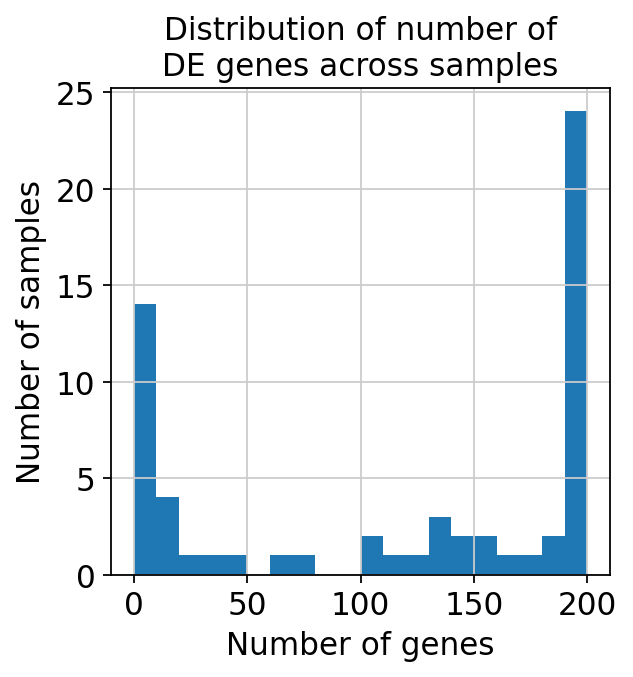

In [15]:
plt.hist(lengths, bins=20);
plt.ylabel('Number of samples')
plt.xlabel('Number of genes');
plt.title('Distribution of number of\nDE genes across samples');

In [16]:
all_de_genes = np.unique([i for j in all_de_genes for i in j])

In [17]:
l2fc = l2fc.loc[all_de_genes]

In [18]:
l2fc.shape

## Clustering by KMeans

In [ ]:
ks = np.concatenate(([2, 3, 4], np.arange(5, 100, 1)))
dists = aug.get_dists(l2fc, ks)

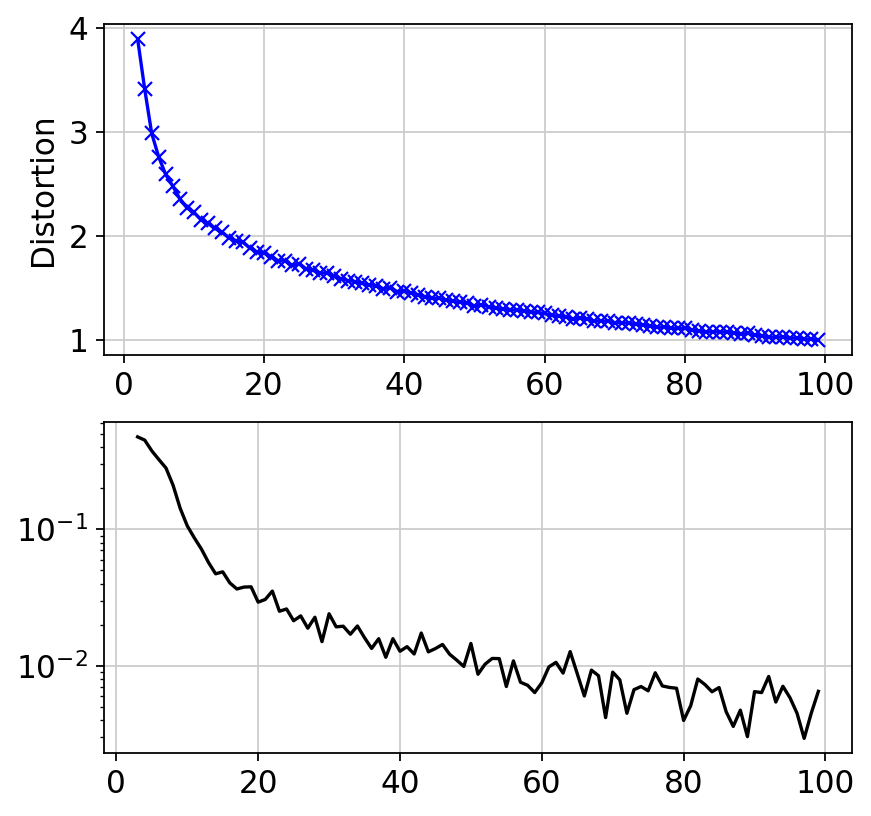

In [184]:
ax = aug.plot_dists(dists, ks, slopes_plot='line', slopes_line_params={'window': 5})
ax[1].set_yscale('log')

In [19]:
n_clusts = 40

In [20]:
kmeans = KMeans(n_clusters=n_clusts, random_state=0).fit(l2fc)

# Make Heatmap

Here I will make the heatmaps that show `log2foldchange` by condition and cell type (ct2).

## First-pass

In [21]:
cmap = plt.get_cmap('Set2')
col_color_iter = it.cycle(cmap.colors)

In [22]:
color_dict = dict(zip(range(n_clusts),col_color_iter))

In [23]:
df_plot = l2fc.iloc[np.argsort(kmeans.labels_), :].T
col_colors = list(map(lambda x: color_dict[x], np.sort(kmeans.labels_)))

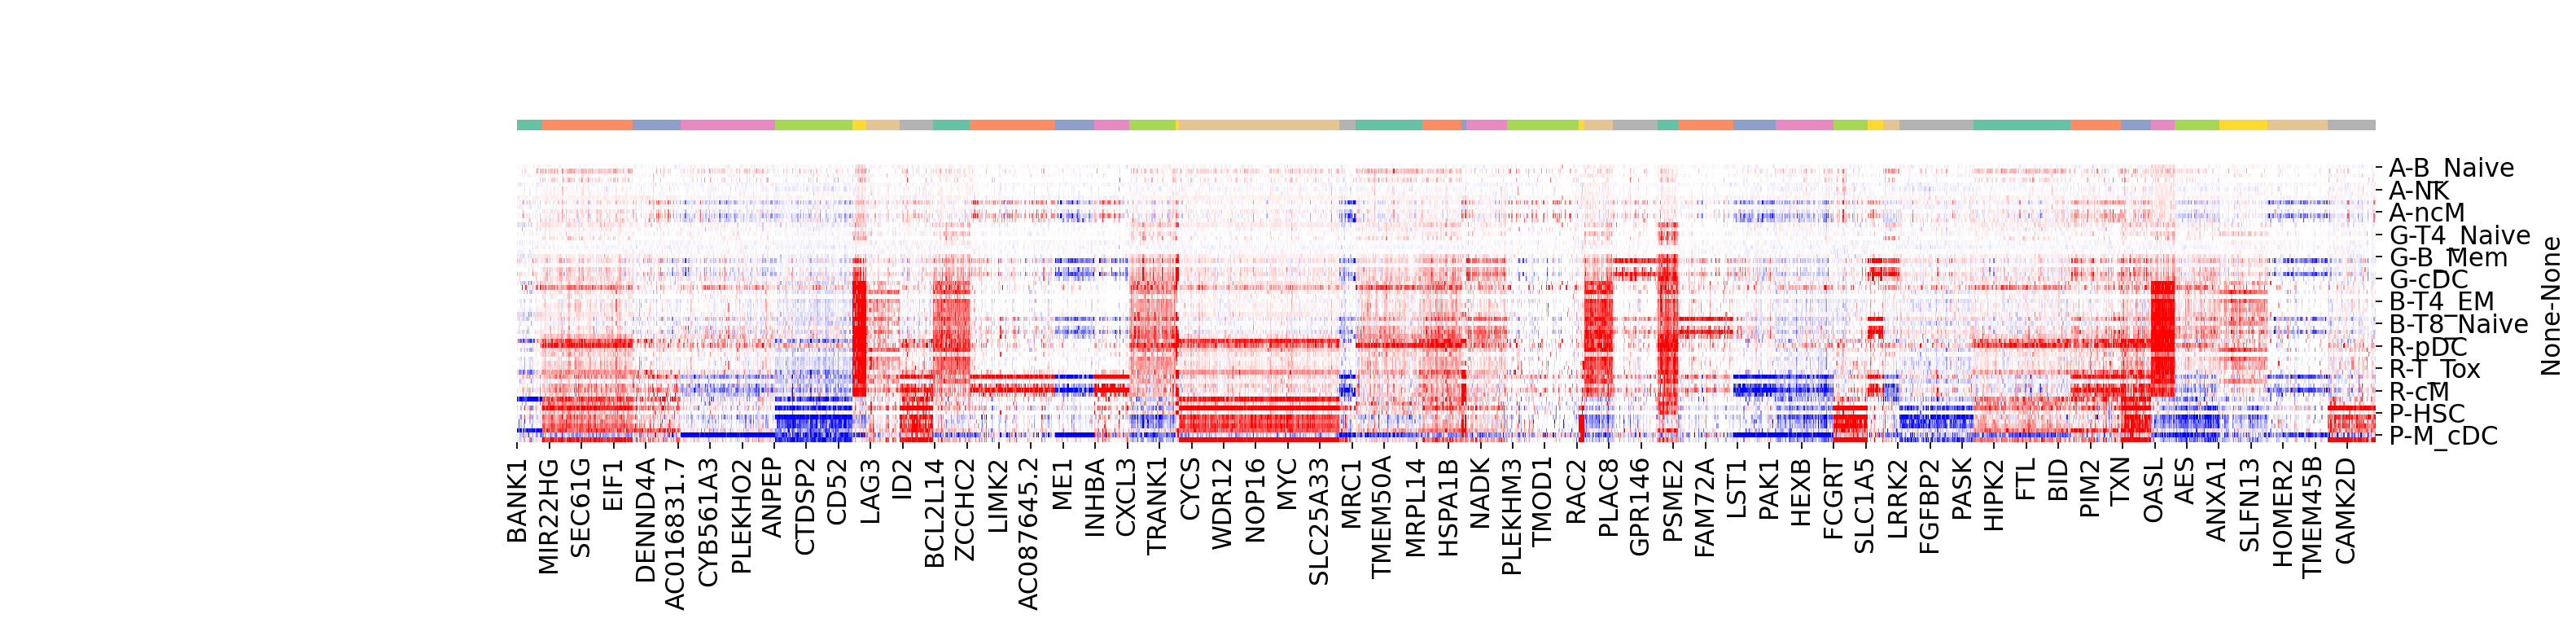

In [24]:
sns.clustermap(df_plot, figsize=(20,5), 
               col_colors=col_colors,
               row_cluster=False, col_cluster=False,
               vmin=-3, vmax=3, cmap='bwr', cbar_pos=None)
plt.tight_layout();

In [25]:
df_plot.shape

(62, 1853)

Since this is hard to interpret, we've decided to:
1. Separate out by condition and cluster the cell types _within_ each condition. 
2. Only show the mean expression per module, not individual genes (since there are so many).
3. Order the k means clusters (a.k.a. modules) using hierarchical clustering along the x axis.

## Using Mean Expression

In [26]:
ordered_conds = [i[0] for i in df_plot.index]
ordered_cts = [i[1] for i in df_plot.index]

In [27]:
modules = np.arange(n_clusts)
modules_genes = dict(zip(modules, [l2fc.index[kmeans.labels_ == i].values for i in range(n_clusts)]))
module_sizes = dict(zip(*np.unique(kmeans.labels_, return_counts=True)))

In [28]:
modules_ordered = np.array([k for j in [[i]*module_sizes[i] for i in module_sizes] for k in j])
pregrouped = df_plot.T.copy()

In [29]:
pregrouped['clust'] = modules_ordered

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
    grouped = pregrouped.groupby('clust').mean()

In [31]:
Z = scipy.cluster.hierarchy.linkage(grouped, method='average', optimal_ordering=True)
module_mean_ordered = aug.get_ordering(Z, grouped.index)
modules_reordered = np.array([k for j in [[i]*module_sizes[i] for i in module_mean_ordered] for k in j])
color_dict = dict(zip(module_mean_ordered, col_color_iter))
col_colors = list(map(lambda x: color_dict[x], modules_reordered))

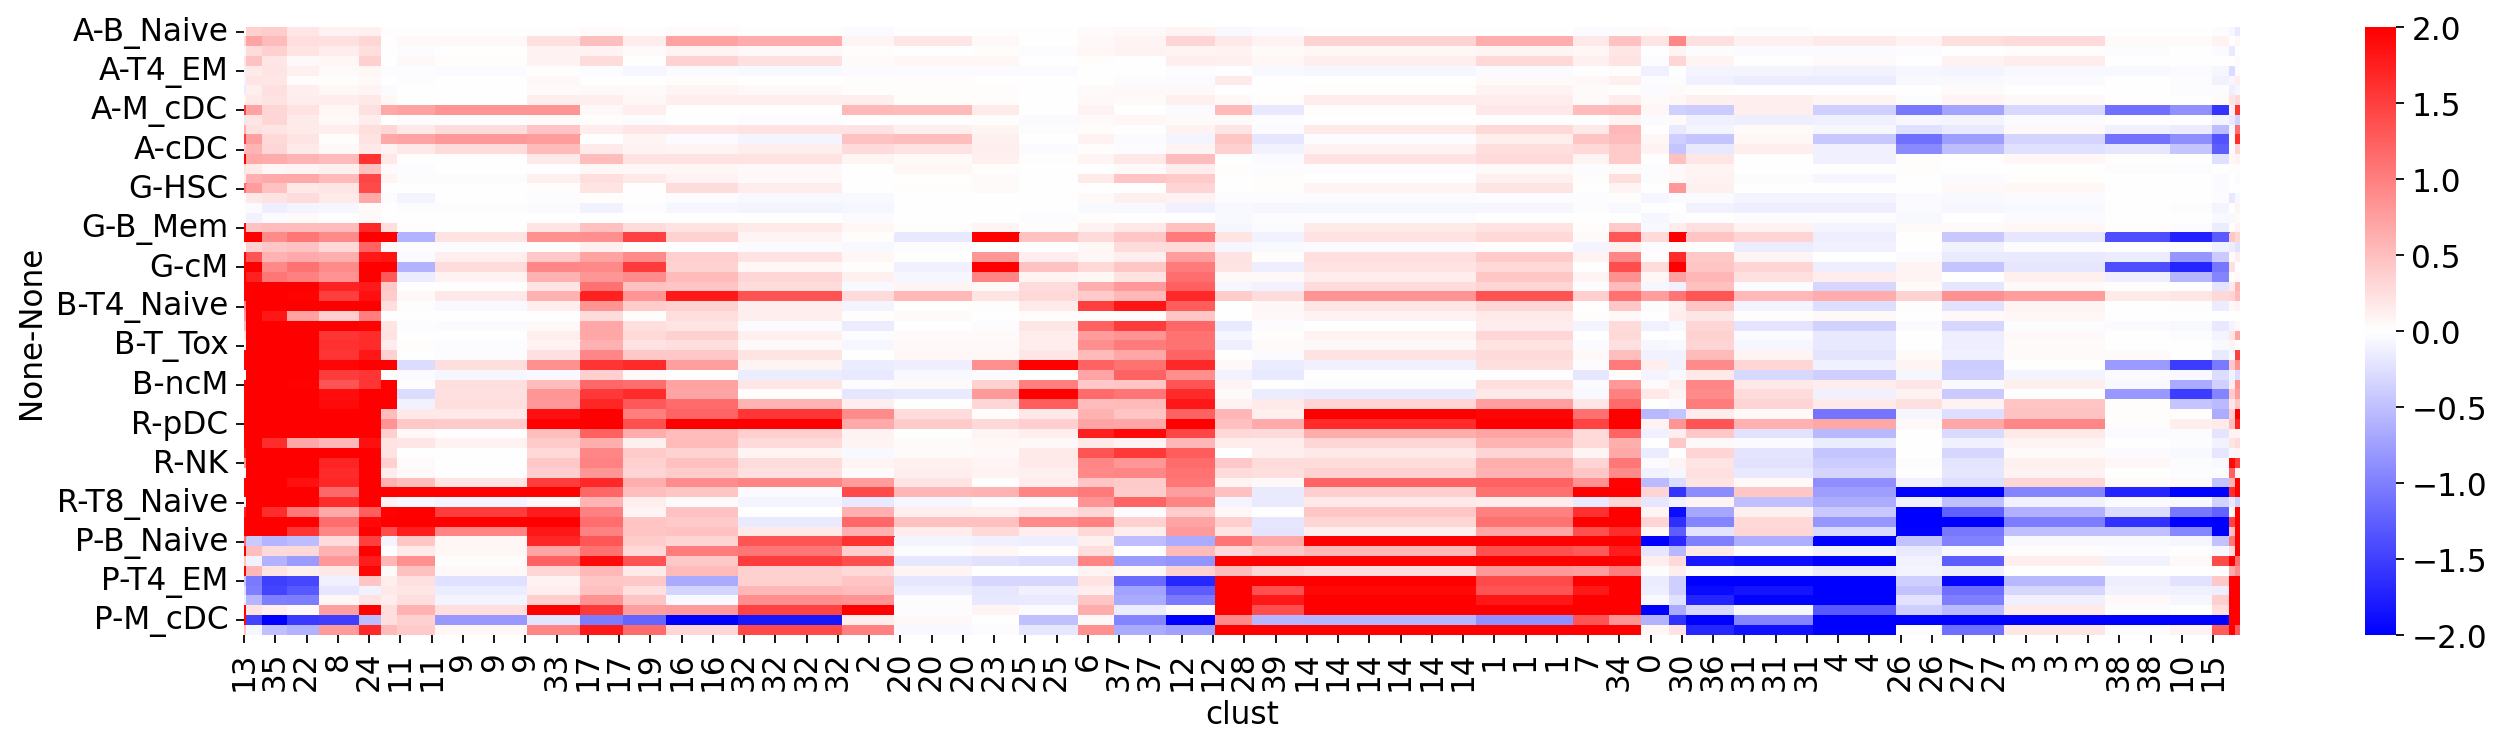

In [32]:
plt.figure(figsize=(20, 5))
sns.heatmap(grouped.T[modules_reordered], cmap='bwr', vmin=-2, vmax=2);

In [33]:
genes_ordered = list()
for module in tqdm(module_mean_ordered):
    Z = scipy.cluster.hierarchy.linkage(df_plot[modules_genes[module]].T, method='average', optimal_ordering=True)
    genes_ordered.append(aug.get_ordering(Z, labels=modules_genes[module]))
genes_ordered = np.concatenate(genes_ordered)

  0%|          | 0/40 [00:00<?, ?it/s]

Define another color for the `M_cDC` cell type group. Going to make it gray.

In [34]:
ct_colors['M_cDC'] = '#808080'

In [35]:
ct_colors

{'T4_Naive': '#98df8a',
 'T4_EM': '#c5b0d5',
 'T8_Naive': '#ffbb78',
 'cM': '#aec7e8',
 'cDC': '#8c564b',
 'ncM': '#1f77b4',
 'B_Naive': '#b5bd61',
 'B_Mem': '#aa40fc',
 'NK': '#ff9896',
 'T_Tox': '#f7b6d2',
 'Mye_PMAI': '#e377c2',
 'pDC': '#279e68',
 'HSC': '#ff7f0e',
 'Plasma': '#c49c94',
 'Mitotic': '#17becf',
 'M_cDC': '#808080'}

### Ungrouped

Showing this first for comparison to the grouped (mean expression).

A


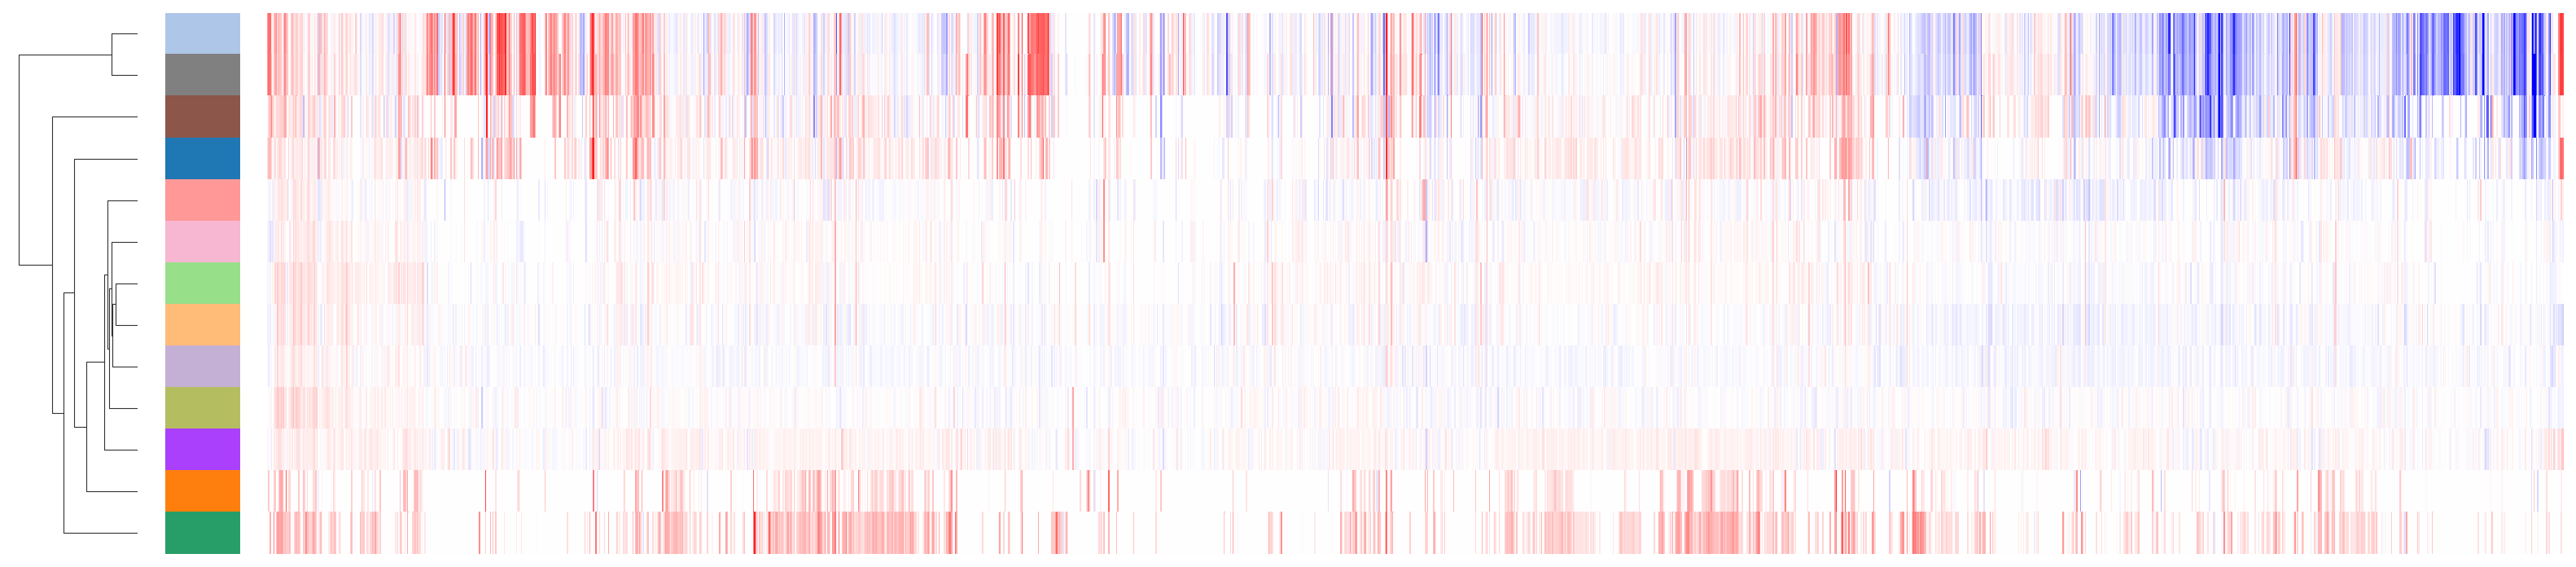

G


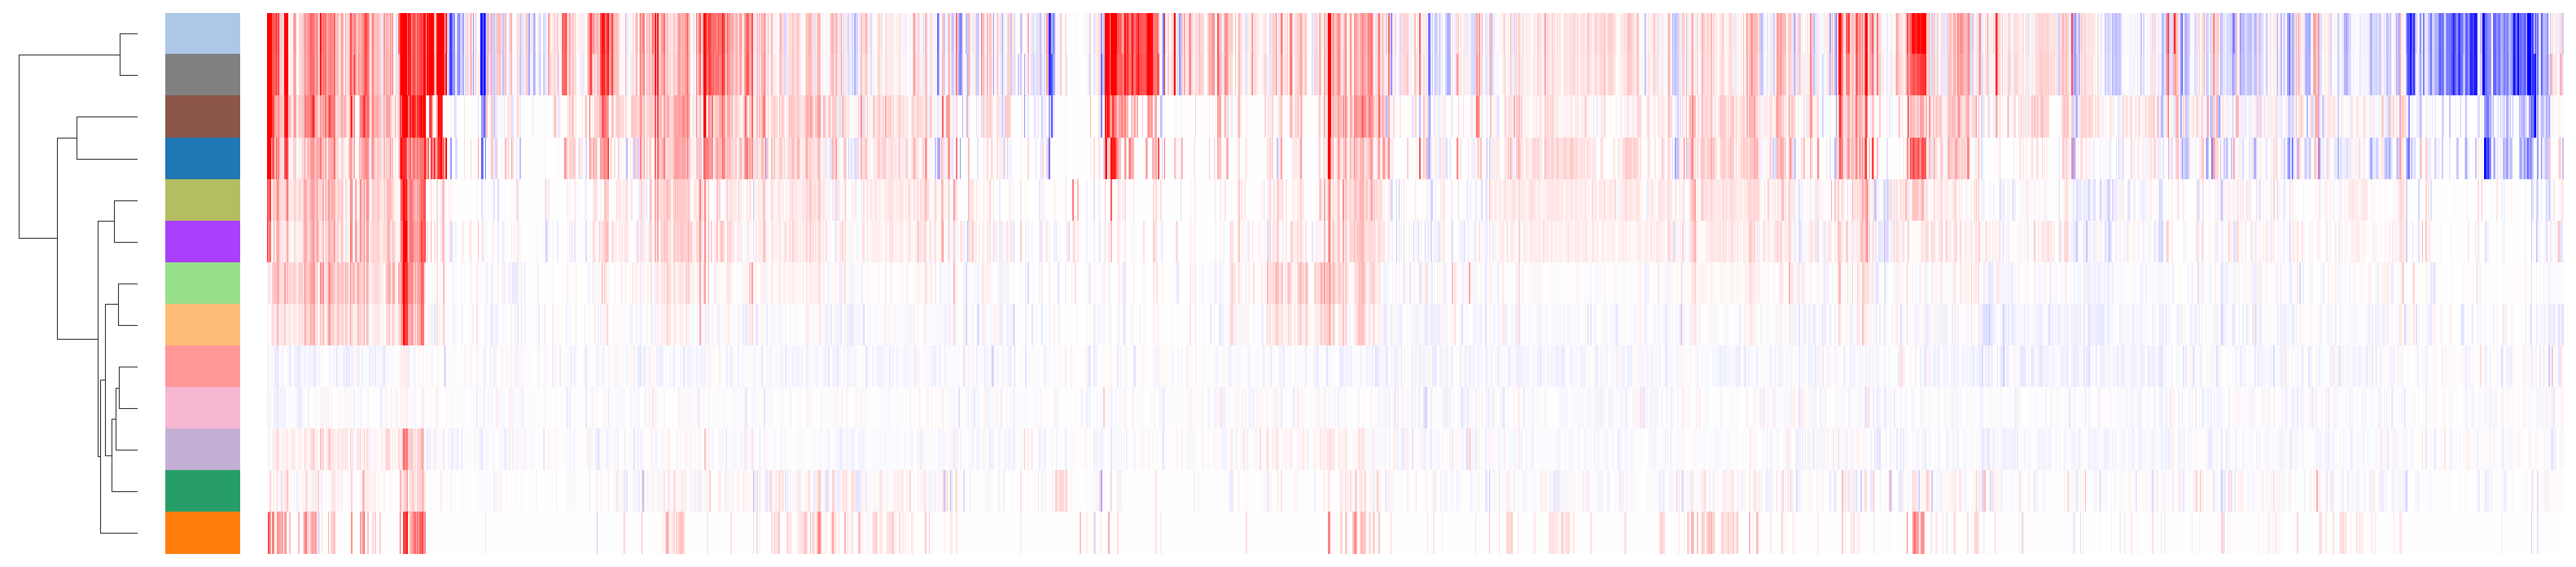

B


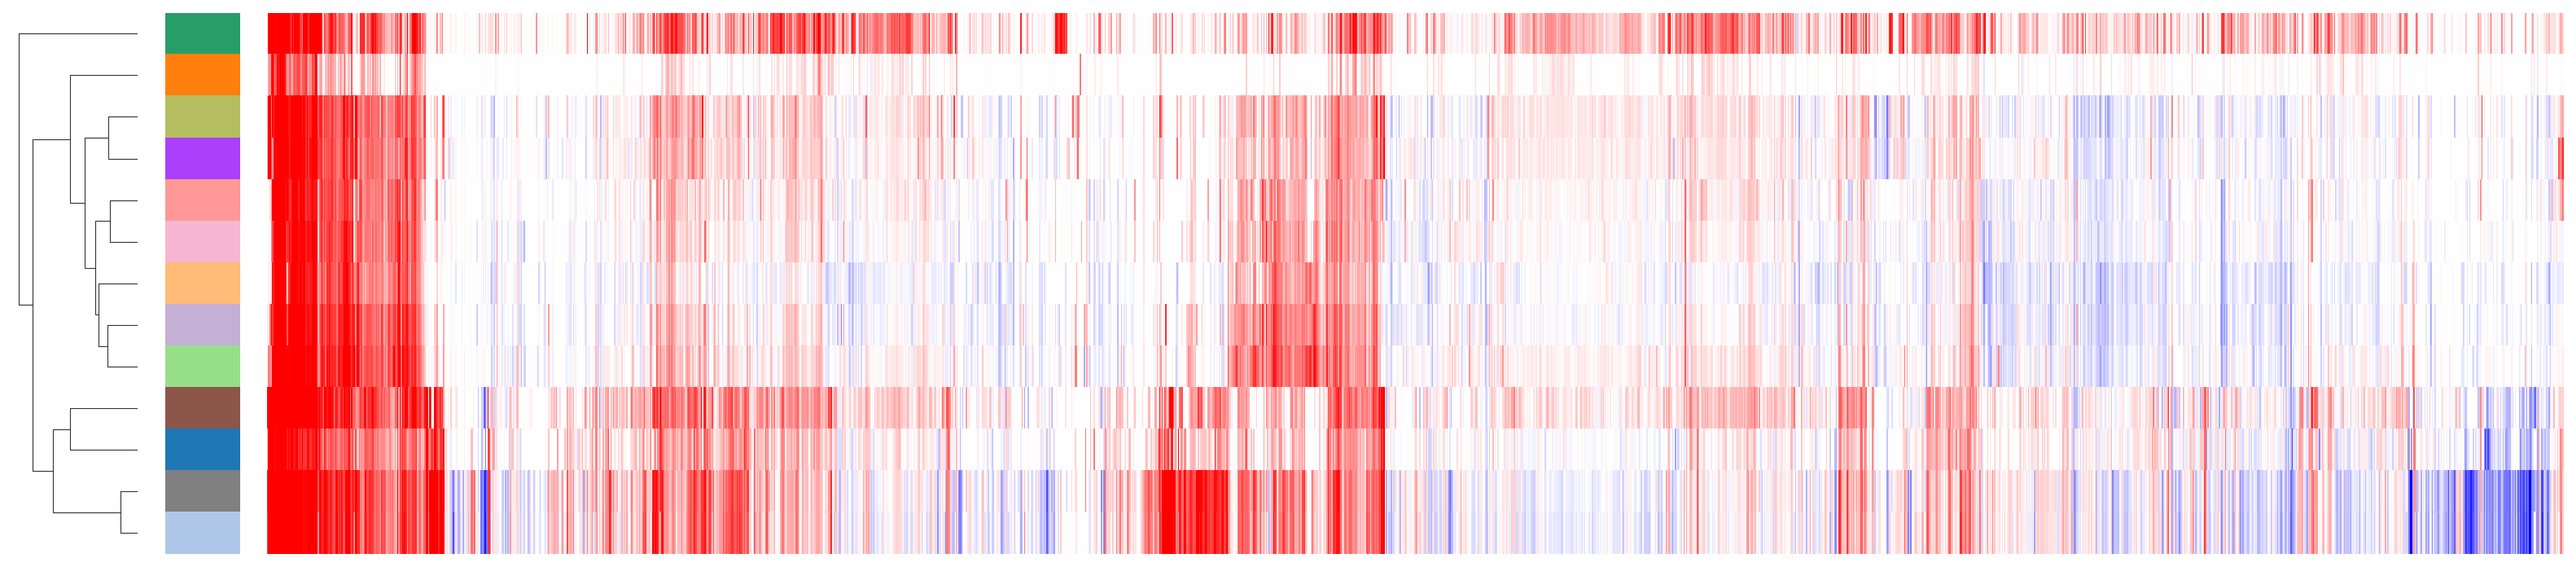

R


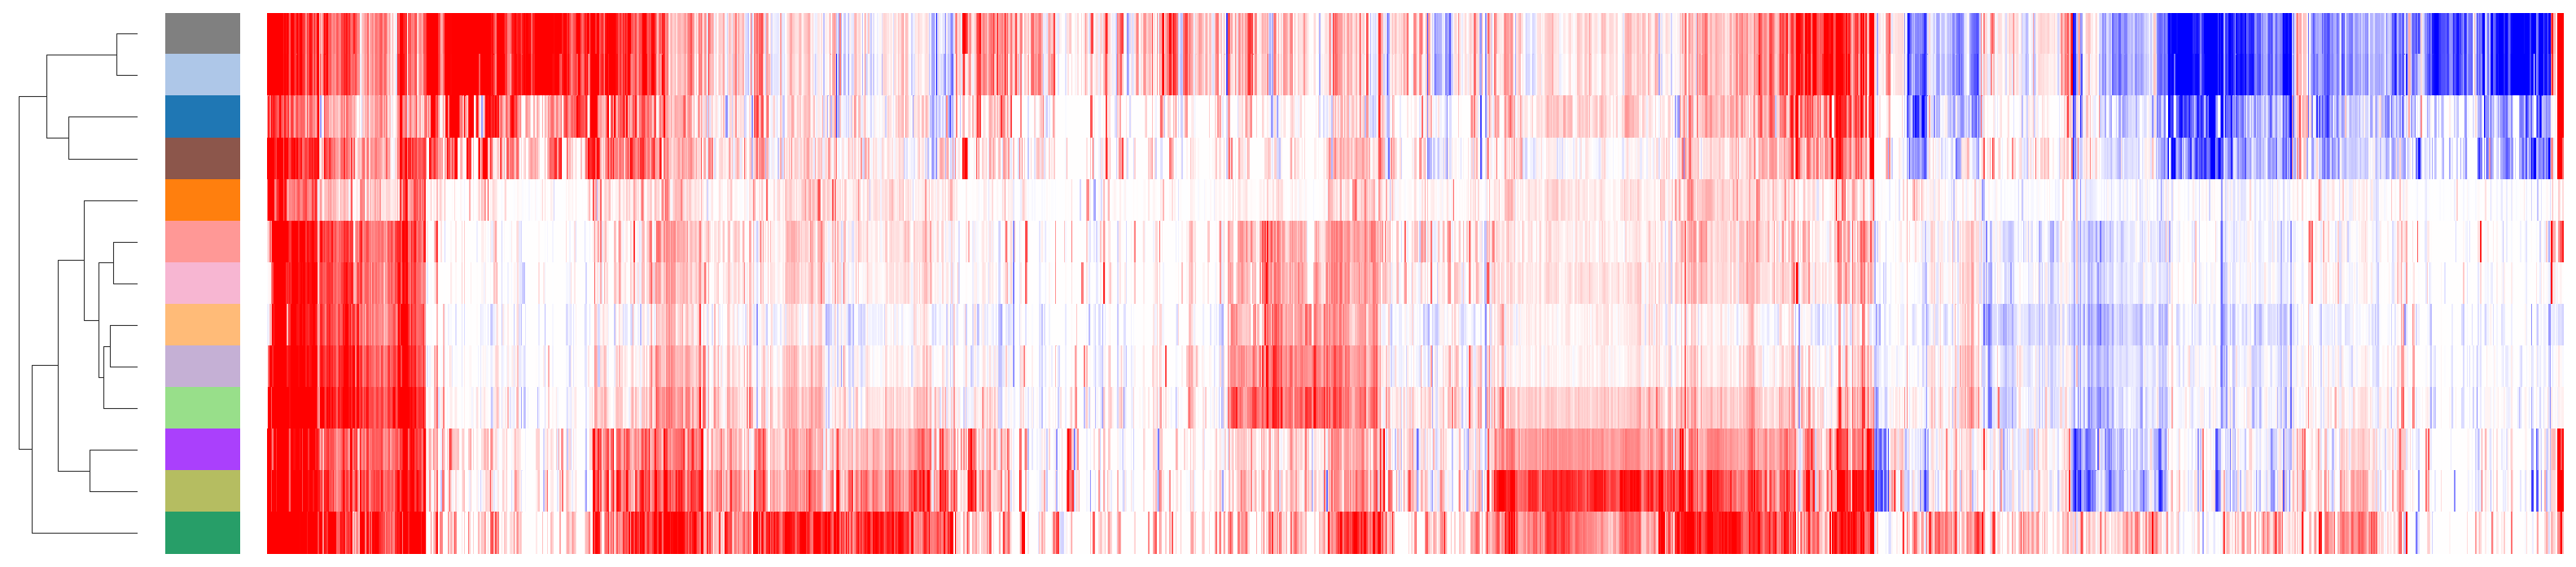

P


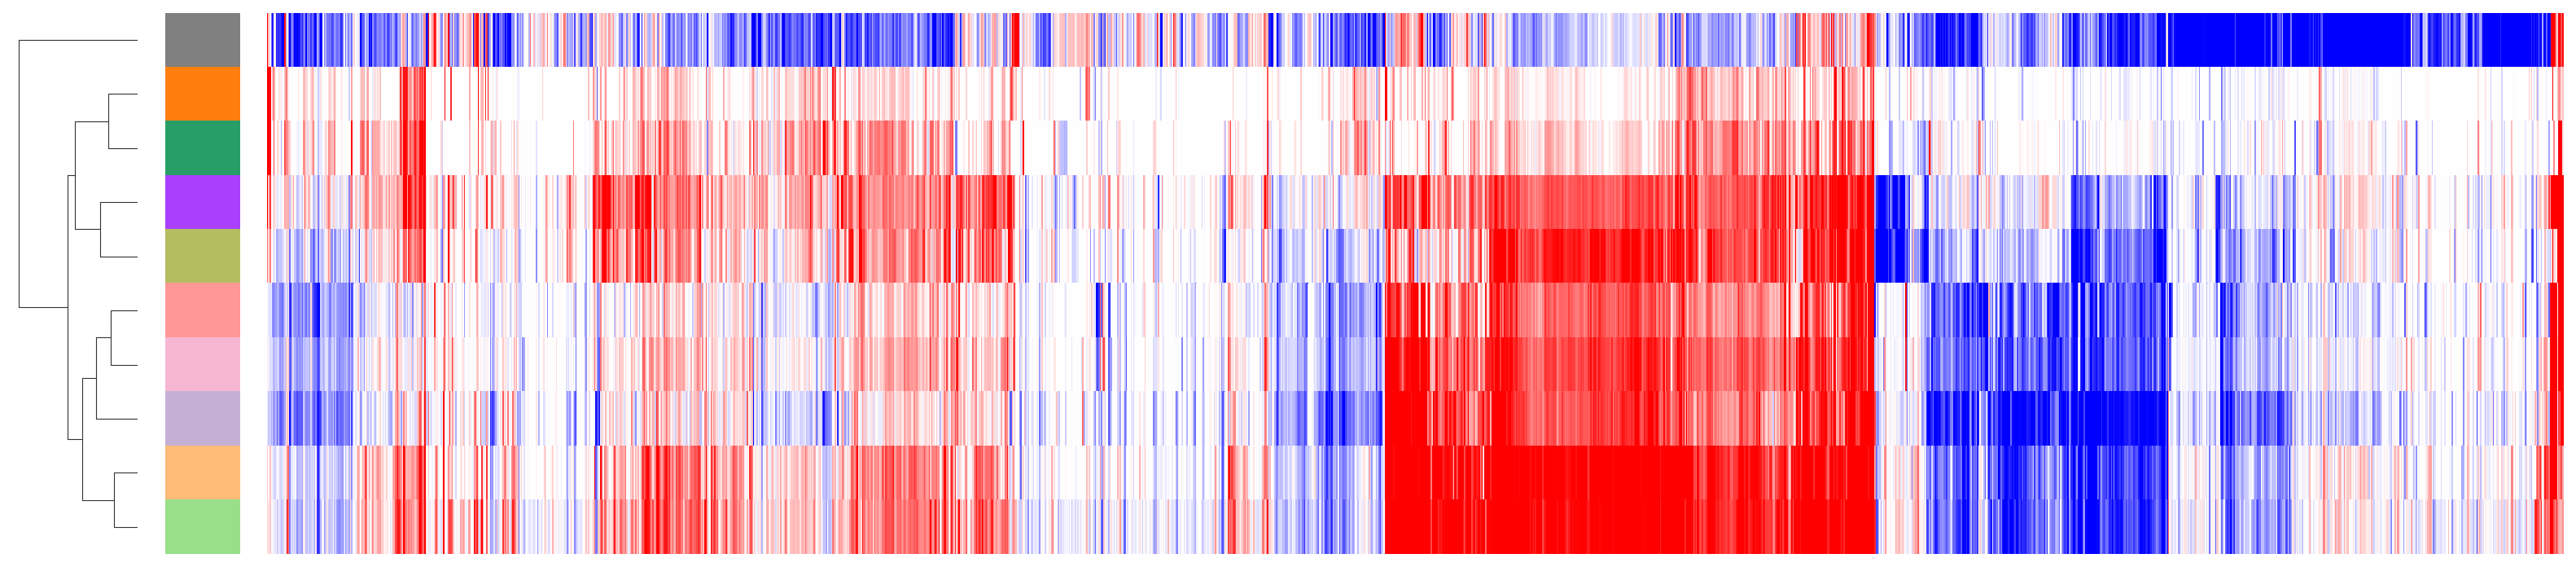

In [36]:
for cond in ['A', 'G', 'B', 'R', 'P']:
    print(cond)
    sub_df = df_plot.loc[cond]
    Z = scipy.cluster.hierarchy.linkage(sub_df, method='average', optimal_ordering=True)
    ordered_cts = aug.get_ordering(Z, sub_df.index)
    cg = sns.clustermap(sub_df[genes_ordered], figsize=(20,5), 
                        row_linkage=Z,
                        col_cluster=False, 
                        row_colors=[ct_colors[ct] for ct in sub_df.index],
                        dendrogram_ratio=0.05, cmap='bwr', vmin=-3, vmax=3, cbar_pos=None
                       );
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.set_xticks([])
    cg.ax_heatmap.set_yticks([])
    plt.tight_layout()
    plt.show()

### Grouped (Mean Expression)

A


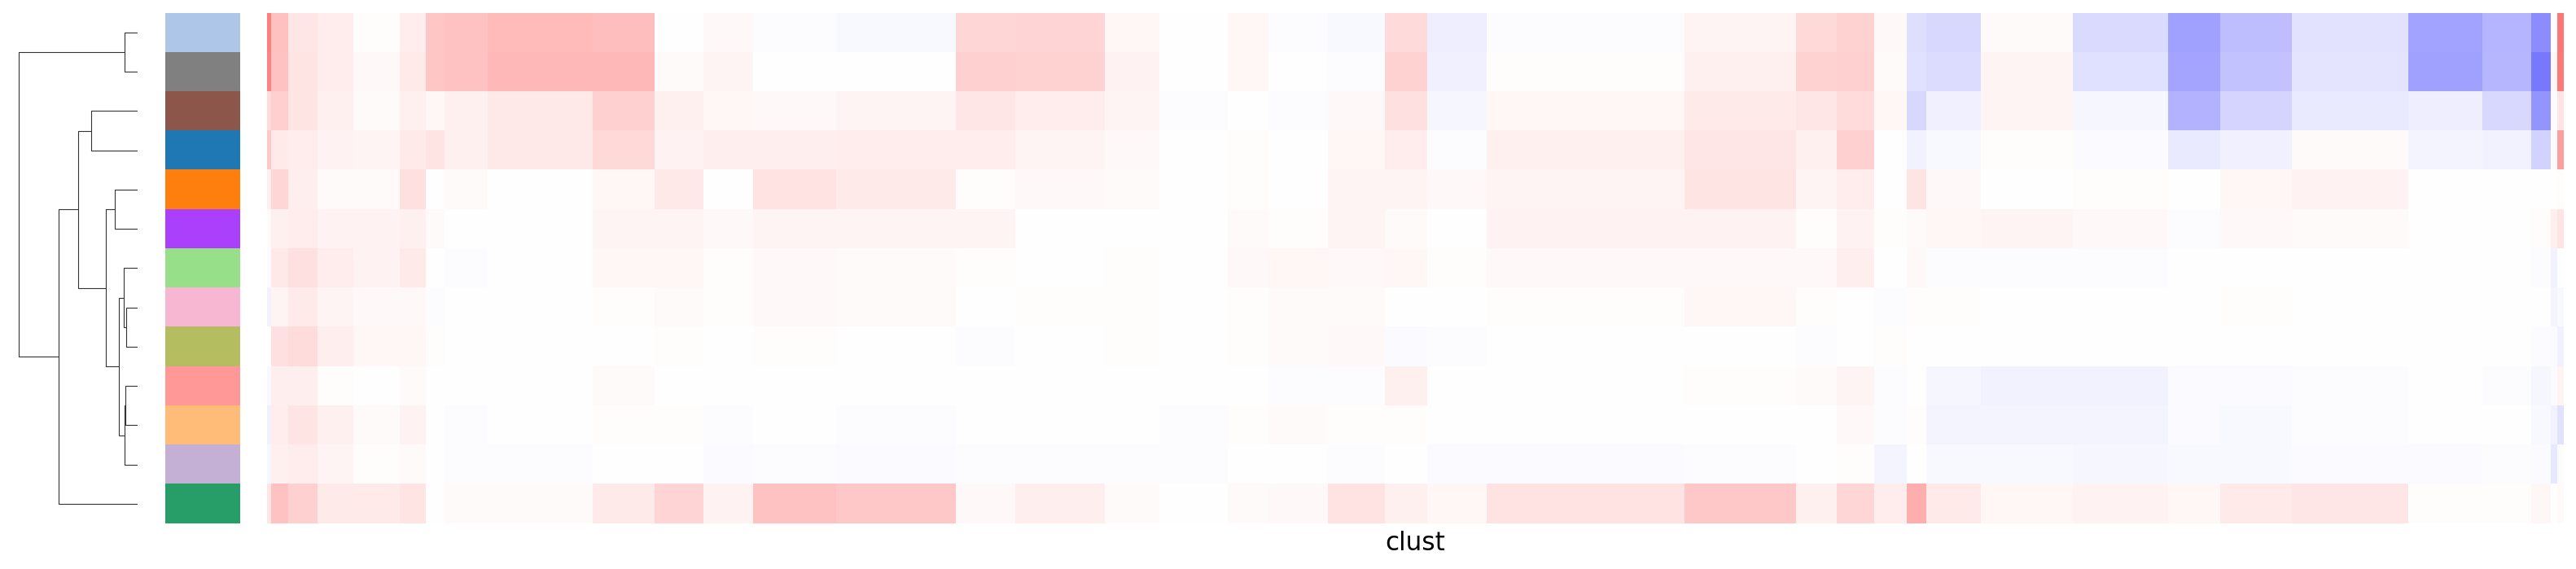

G


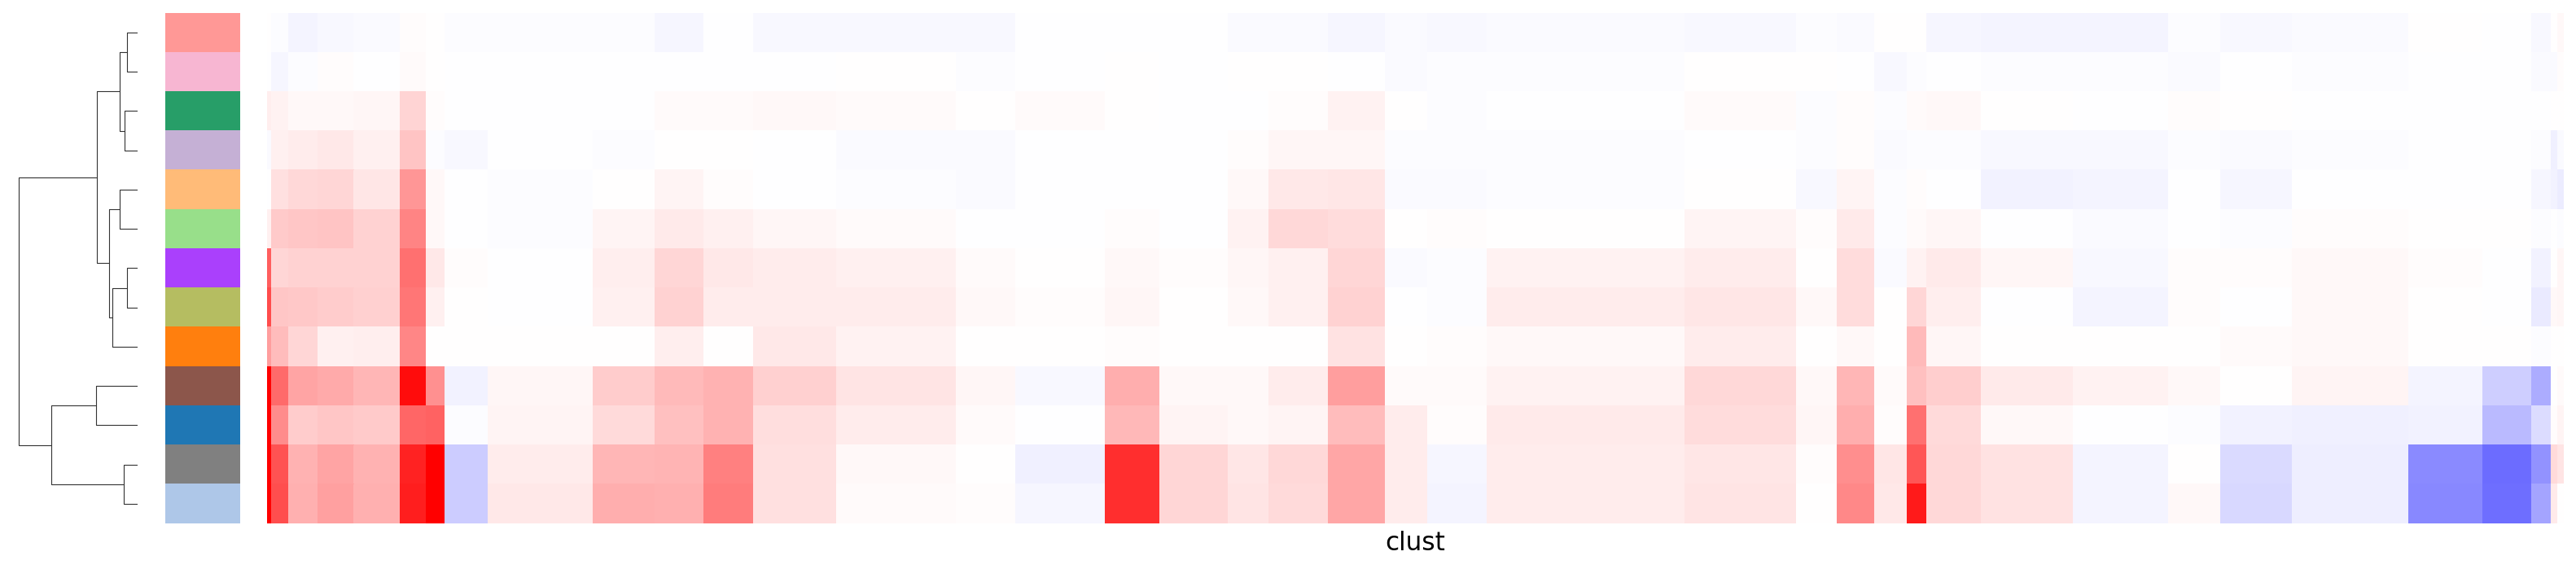

B


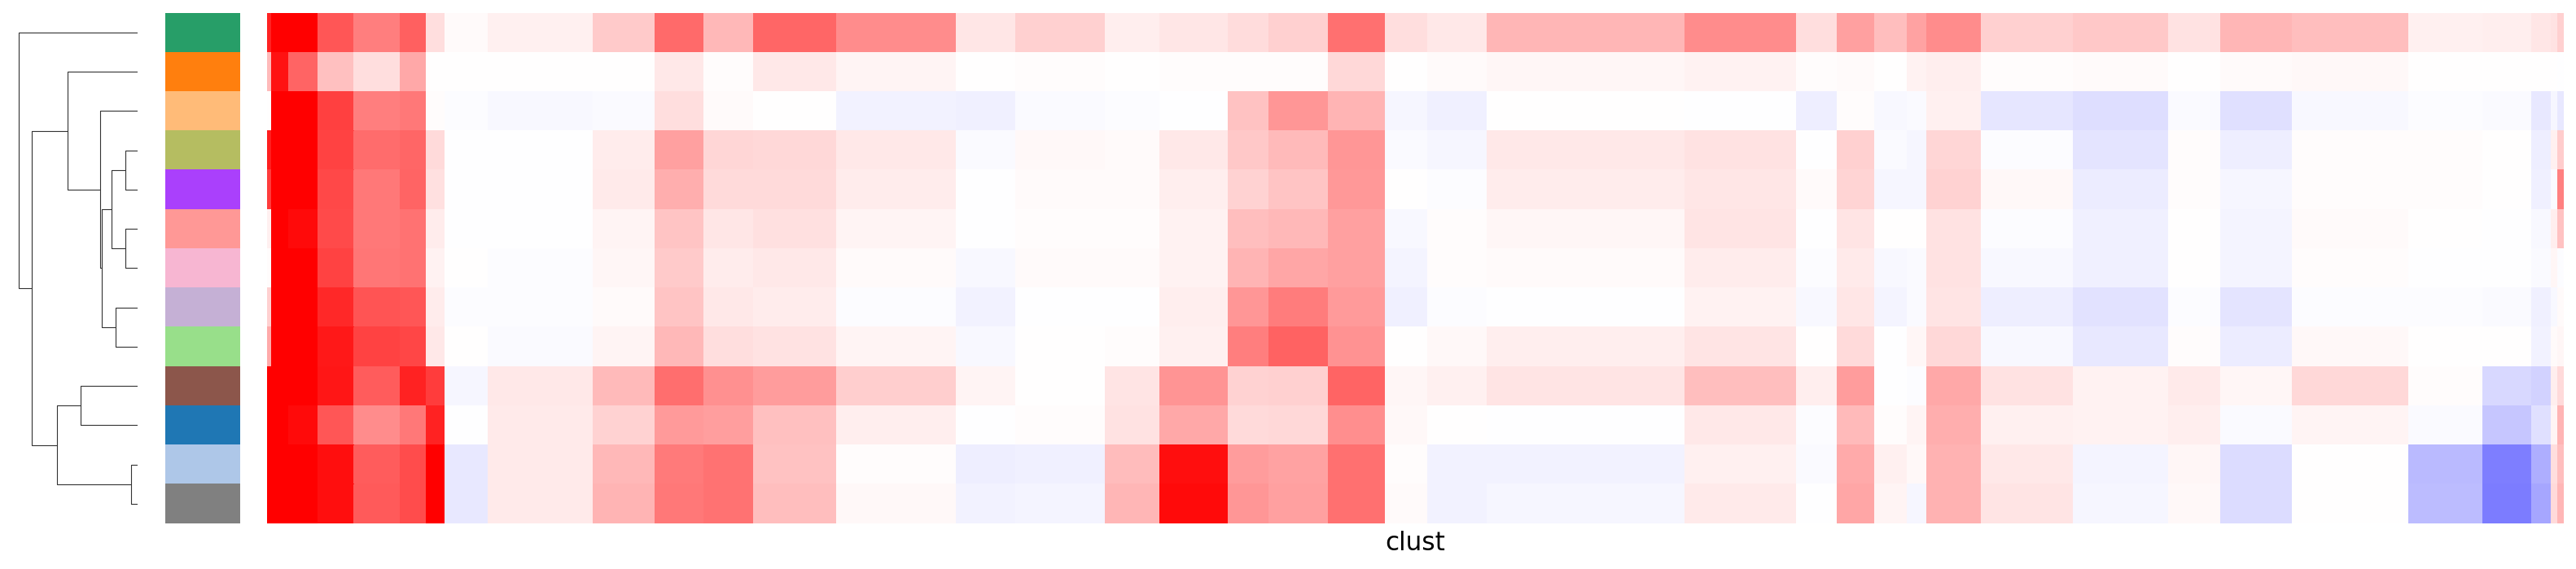

R


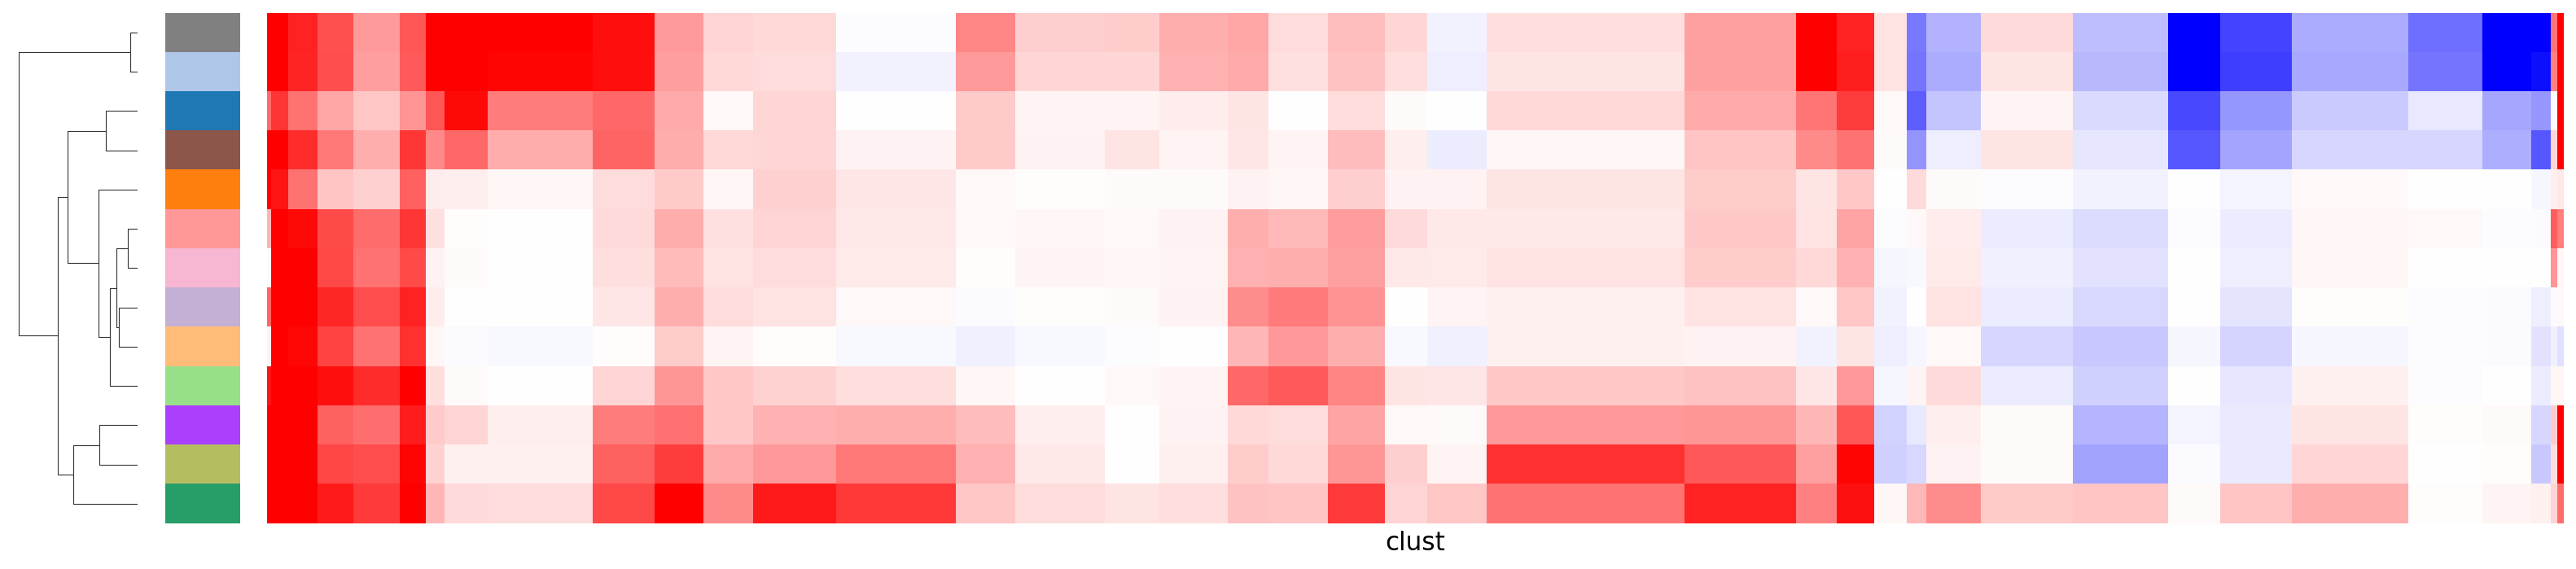

P


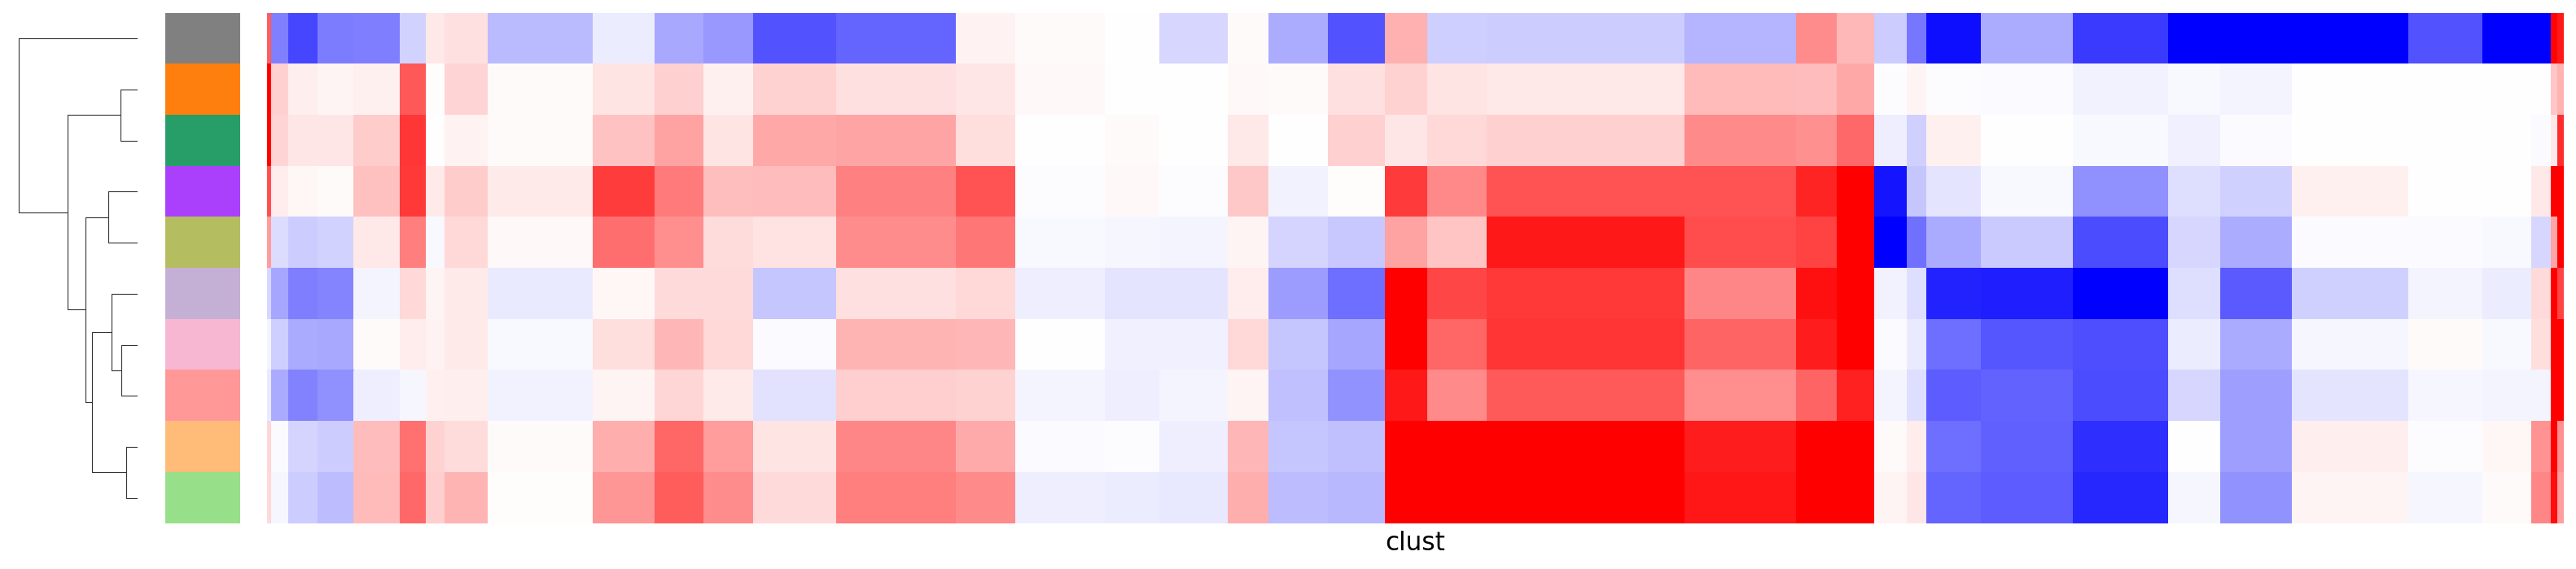

In [37]:
for cond in ['A', 'G', 'B', 'R', 'P']:
    print(cond)
    sub_df = grouped.T[modules_reordered].loc[cond]
    Z = scipy.cluster.hierarchy.linkage(sub_df, method='average', optimal_ordering=True)
    ordered_cts = aug.get_ordering(Z, sub_df.index)
    cg = sns.clustermap(sub_df, figsize=(20,5), 
                        row_linkage=Z,
                        col_cluster=False, 
                        row_colors=[ct_colors[ct] for ct in sub_df.index],
                        dendrogram_ratio=0.05, cmap='bwr', vmin=-3, vmax=3, cbar_pos=None
                       );
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.set_xticks([])
    cg.ax_heatmap.set_yticks([])
    plt.tight_layout()
    plt.show()

This looks a lot cleaner and is easier to interpret with >1000 genes.

Now to export the peripherals (color bars, scale bars, etc.) so that I can assemble them in Illustrator. For my own reference, I will make a little figure showing where the numbered modules are. It's hard to tell because colors are reused but the numbers are out of order.

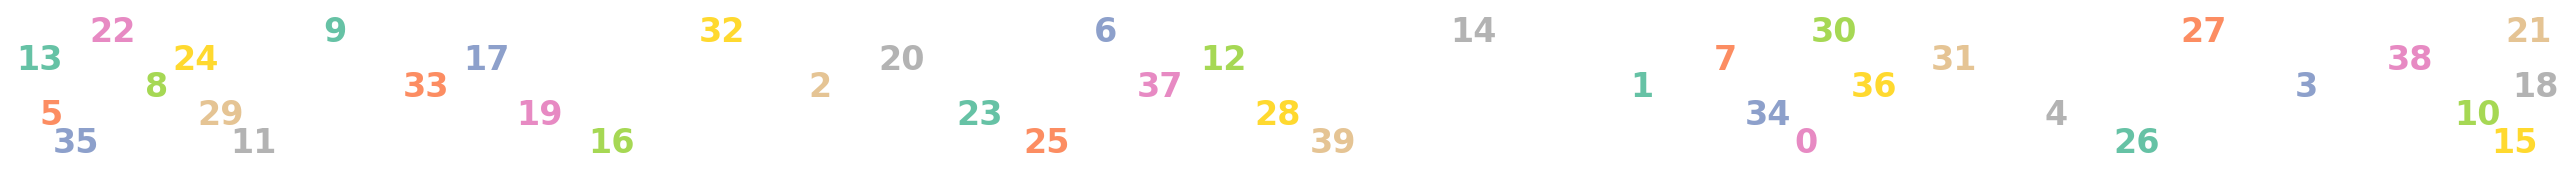

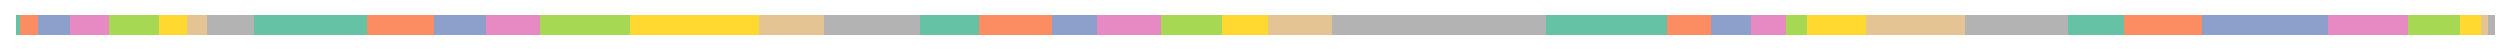

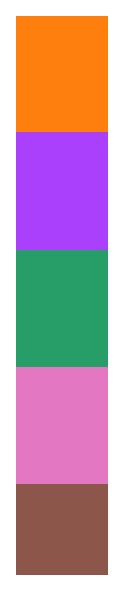

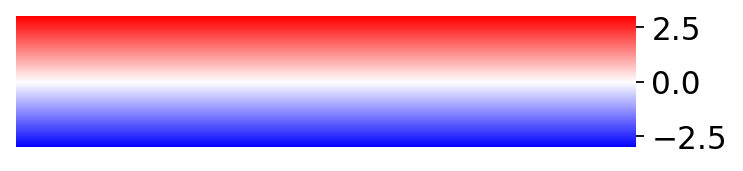

In [38]:
indexes = np.unique(modules_reordered, return_index=True)[1]
modules_reordered_unique = [modules_reordered[index] for index in sorted(indexes)]

width = 20
plt.figure(figsize=(width,1))
plt.scatter(range(width), [0]*width, s=0)
y_pos = np.linspace(-0.05, 0.05, 5)
xs = list()
for c, y in zip(modules_reordered_unique, it.cycle(np.random.choice(y_pos, size=y_pos.shape[0], replace=False))):
    x = (np.where(modules_reordered == c)[0].mean()/df_plot.shape[1])*width
    xs.append(x)
    plt.text(x, y, str(c), size=15, color=color_dict[c], ha='center', fontdict={'weight':1000})
plt.xlim((min(xs), max(xs)))
plt.gca().axis('off');

cg = sns.clustermap(df_plot[genes_ordered], figsize=(20,5), 
                    col_colors=col_colors, 
                    row_cluster=False, col_cluster=False,
                    vmin=-3, vmax=3, cmap='bwr', cbar_pos=None)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_heatmap.set_visible(False)
plt.tight_layout()
plt.show()

cg = sns.clustermap(df_plot, figsize=(20,5), 
                    row_colors=[cond_colors[cond] for cond in ordered_conds],
                    row_cluster=False, col_cluster=False,
                    vmin=-3, vmax=3, cmap='bwr', cbar_pos=None)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_heatmap.set_visible(False)
plt.tight_layout()
plt.show()

cg = sns.clustermap(df_plot, figsize=(20,5), 
                    row_cluster=False, col_cluster=False,
                    vmin=-3, vmax=3, cmap='bwr')
cg.ax_col_dendrogram.set_visible(False)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_heatmap.set_visible(False)
plt.tight_layout()
plt.show()

# Run Functional Enrichment

Here, I use the ToppFun functional enrichment API (implemented in nero.Augustus). I run it on each module and organize the results, which I use to annotate each cluster.

In [39]:
tfun = aug.toppfun(df_plot.columns.tolist())

In [40]:
enrich = dict()
for module in tqdm(modules):
    tfun.enrich(modules_genes[module])
    enrich[module] = tfun.copy()

  0%|          | 0/40 [00:00<?, ?it/s]

## Export

In [61]:
# with open(prefix_mrna + 'pkls/enrich.pkl', 'wb') as file:
#     pkl.dump(enrich, file)
    
with open(prefix_mrna + 'pkls/enrich.pkl', 'rb') as file:
    enrich = pkl.load(file)

Explore results.

In [62]:
def disp_mod(module, query_params=['BP', '0.05'], disp_params=['display.max_rows', 100, 'display.max_columns', 10, 'display.max_colwidth', None]):
    cat_map = {
        'BP': 'GeneOntologyBiologicalProcess',
        'MF': 'GeneOntologyMolecularFunction',
        'CC': 'GeneOntologyCellularComponent',
    }
               
    query_params[0] = cat_map[query_params[0]]
    query_str = "(Category == '%s') & (QValueFDRBH < %s)" % tuple(query_params)
    df = enrich[module].res_filter(query_str).sort_values(by='-log10FDR', ascending=False)
    with pd.option_context(*disp_params):
        display(df)
    return

In [65]:
enrich[16].genes_query

array(['AC004687.1', 'ARID5A', 'B2M', 'BIRC3', 'BTG1', 'C21orf91',
       'C6orf62', 'CALCRL', 'CALM1', 'CAST', 'CCSER2', 'CD2AP', 'CLDND1',
       'CLIC1', 'CYLD', 'DENND1B', 'FAM177A1', 'FTH1', 'FYTTD1', 'GNG5',
       'GPBP1', 'GUK1', 'HLA-A', 'HLA-B', 'HMGN2', 'HSP90B1', 'HSPB1',
       'LACTB', 'LGMN', 'LILRB1', 'LILRB4', 'LYN', 'MALAT1', 'MARCKS',
       'MRPL14', 'MSN', 'MSRB1', 'MYO1G', 'NAGK', 'NEAT1', 'NEK8', 'OST4',
       'PDE7A', 'PIK3AP1', 'PPDPF', 'RAB29', 'RAB8A', 'RNASEH2B',
       'RNF19B', 'RUNX3', 'S100A11', 'SEC11A', 'SLC15A4', 'SMC6', 'SNX6',
       'SPART', 'SQSTM1', 'TANK', 'TIPARP', 'TMEM123', 'TMEM50A', 'TOMM7',
       'TPM3', 'TRAM1', 'TSPAN33', 'UBC', 'USP25'], dtype=object)

In [63]:
disp_mod(16, query_params=['CC', '0.05'])

,Category,Name,-log10FDR,Genes
ID,,,,
GO:0042612,GeneOntologyCellularComponent,MHC class I protein complex,2.985595,"[HLA-A, HLA-B, B2M]"
GO:0042824,GeneOntologyCellularComponent,MHC class I peptide loading complex,2.985595,"[HLA-A, HLA-B, B2M]"
GO:0030139,GeneOntologyCellularComponent,endocytic vesicle,2.985595,"[HSP90B1, UBC, HLA-A, HLA-B, CD2AP, B2M, FTH1, RAB8A]"
GO:0140534,GeneOntologyCellularComponent,endoplasmic reticulum protein-containing complex,2.985595,"[HSP90B1, HLA-A, HLA-B, OST4, SEC11A, B2M]"
GO:0042611,GeneOntologyCellularComponent,MHC protein complex,2.269830,"[HLA-A, HLA-B, B2M]"
GO:0098552,GeneOntologyCellularComponent,side of membrane,2.257975,"[CYLD, HLA-A, HLA-B, B2M, TMEM123, GNG5, LYN, LILRB1, LILRB4, MSN]"
GO:0032398,GeneOntologyCellularComponent,MHC class Ib protein complex,2.257975,"[HLA-A, HLA-B]"
GO:0030666,GeneOntologyCellularComponent,endocytic vesicle membrane,2.257975,"[UBC, HLA-A, HLA-B, B2M, RAB8A]"
GO:0031901,GeneOntologyCellularComponent,early endosome membrane,2.257975,"[HLA-A, HLA-B, SNX6, SLC15A4, B2M]"
